# DS Project Employee Churn (KNN)

> ---- KNN Flow------

> 1. Encoding Categorical Variables
> - labelEncoding for 'department', 'left' 
> - ordinalEncoding for 'salary' (low = 0, medium = 1, high = 2)

> 2. Split the data for training and testing 

> 3. Scaling the data - using StandardScaler 
     * non-scaled data had about 81% of accuracy rate
     
> 4. Find the best 'k' & Fit to KNN (Scaled data)
> - first tried to find by manual iteration : accuracy rate was 70%, with best k = 18
> - **then used GridSearch (weights = 'uniform') : best k = 14, accuracy rate : 84.4%
>   * GridSearch automatically performs cross-validation and selects the best hyperparameters based on the performance on the validation set
> - [graph] Accuracy rate by K
> - ** when setting the 'weights = distance' parameter, the accuracy rate increased slightly. (best k = 15, accuracy rate : 84.5%)
> - ** even though the best k for test dataset was k = 18, overall accuracy rate and recall were higher when k= 15

> 5. Result of modeling
> - accuracy rate : in-sample, out-of-sample are almost same (no overfitting)
> - confusion matrix : recall vs precision?
> - feature importance (unusual for KNN but tried using permutation_importance)
    
> 6. Visualization : decision boundary graph  ( ++ balancing the dataset for better separation)
> - Imbalanced VS balanced using SMOTE
>    * all features using 2D PCA  &  feature importance by PCA
>    * avg_hrs_month vs Satisfaction (most impactful ones from feature importance)
>    * tenure vs review (much less discriminative results)

> - SMOTE (Synthetic Minority Over-sampling Technique) : Oversampling - Increase the number of instances in the minority class by duplicating existing samples or generating synthetic samples using methods 

In [1]:
from sklearn.model_selection import GridSearchCV
from pandas import Series, DataFrame
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('employee_churn_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


## Encoding Categorical Variables

In [4]:
# Encode the department variable
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Initialize the LabelEncoder
labelEncoder = LabelEncoder()
df['department'] = labelEncoder.fit_transform(df['department'])

# Print the mapping of 'department' encoding
print("Department Encoding:")
for numeric_label, original_value in enumerate(labelEncoder.classes_):
    print(f"Encoded Value: {numeric_label} -> Original Value: {original_value}")

Department Encoding:
Encoded Value: 0 -> Original Value: IT
Encoded Value: 1 -> Original Value: admin
Encoded Value: 2 -> Original Value: engineering
Encoded Value: 3 -> Original Value: finance
Encoded Value: 4 -> Original Value: logistics
Encoded Value: 5 -> Original Value: marketing
Encoded Value: 6 -> Original Value: operations
Encoded Value: 7 -> Original Value: retail
Encoded Value: 8 -> Original Value: sales
Encoded Value: 9 -> Original Value: support


In [5]:
# Fit the OrdinalEncoder on 'salary' 
salary_mapping = {
    'low': 0,
    'medium': 1,
    'high': 2
}

# Apply ordinal encoding to the 'salary' column
df['salary'] = df['salary'].map(salary_mapping)

In [6]:
# Encode the 'left' variable
df['left'] = labelEncoder.fit_transform(df['left'])

# Print the mapping of 'left' encoding
print("Left Encoding:")
for numeric_label, original_value in enumerate(labelEncoder.classes_):
    print(f"Encoded Value: {numeric_label} -> Original Value: {original_value}")

Left Encoding:
Encoded Value: 0 -> Original Value: no
Encoded Value: 1 -> Original Value: yes


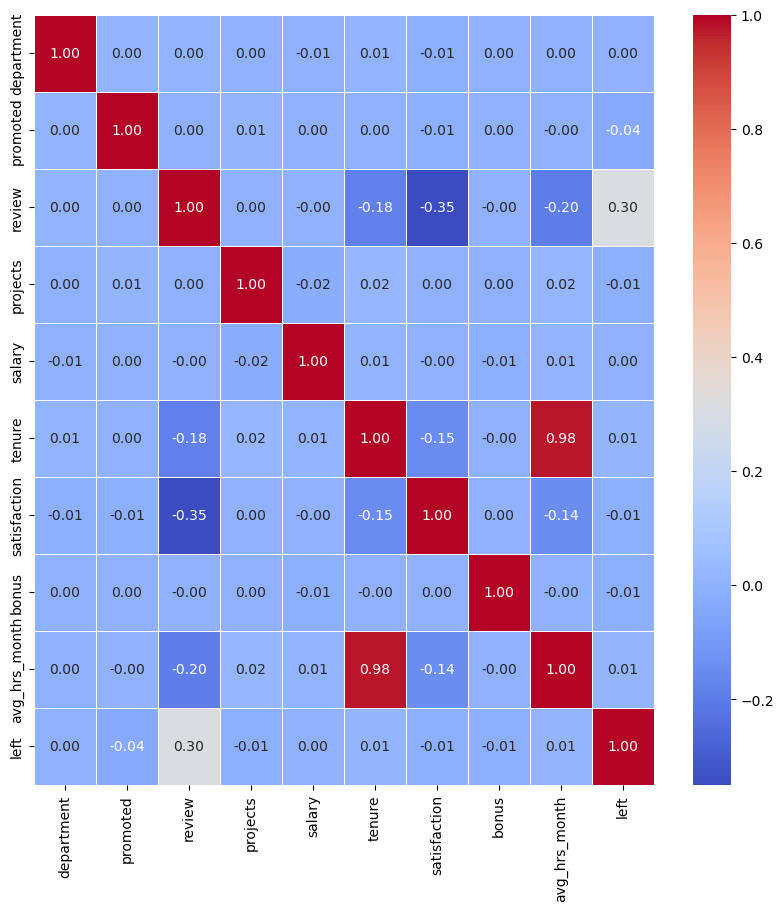

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,linewidths=0.6,fmt=".2f",cmap="coolwarm");

> Here you can see, there's zero correlation between 'department' and 'left'. To analyze with focused data, we decided to rule out this for our modeling.

## Splitting Data into Train and Test Sets

In [8]:
# drop the department 
df_dropDepart = df.drop('department', axis =1)

In [9]:
df_dropDepart

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,0,0.577569,3,0,5.0,0.626759,0,180.866070,0
1,0,0.751900,3,1,6.0,0.443679,0,182.708149,0
2,0,0.722548,3,1,6.0,0.446823,0,184.416084,0
3,0,0.675158,4,2,8.0,0.440139,0,188.707545,0
4,0,0.676203,3,2,5.0,0.577607,1,179.821083,0
...,...,...,...,...,...,...,...,...,...
9535,0,0.610988,4,1,8.0,0.543641,0,188.155738,1
9536,0,0.746887,3,1,8.0,0.549048,0,188.176164,1
9537,0,0.557980,3,0,7.0,0.705425,0,186.531008,1
9538,0,0.584446,4,1,8.0,0.607287,1,187.641370,1


In [10]:
X = df_dropDepart.drop('left', axis=1)
y = df_dropDepart['left']

In [11]:
#split data into train and test (75/25)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Scale the data - necessary for KNN

In [12]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Find the best 'k'

### accuracy without doing scaling

In [13]:
# Define the range of k values to try
k_values = range(1, 20)

best_k = None
best_accuracy = 0

for k in k_values:
    # Create and train the KNN model with the current value of k
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy score for the current k
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if the current k gives better accuracy than the previous best
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f"Best k: {best_k}")
print(f"Best accuracy: {best_accuracy}")

Best k: 9
Best accuracy: 0.810482180293501


### find the best k manually (scaled data)

In [14]:
# Manual loop 

from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for k in range(1,30):

    knn = KNeighborsClassifier(k) #n_neighbors
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train_scaled,y_train))
    test_scores.append(knn.score(X_test_scaled,y_test))
    
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(round(max_train_score*100,2), list(map(lambda x: x+1, train_scores_ind))))


## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(round(max_test_score*100,2), list(map(lambda x: x+1, test_scores_ind))))

Max train score 71.31 % and k = [18]
Max test score 70.1 % and k = [18]


### find the best k by GridSearch (scaled data)

In [15]:
## Define a range of k values to search
param_grid = {'n_neighbors': np.arange(1, 20)}

# Initialize KNN classifier
knn = KNeighborsClassifier(metric='euclidean')

# Initialize GridSearchCV to find the best k

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best k value and its corresponding accuracy
print("----Best K values for train_scaled data----")
print("Best k:", grid_search.best_params_['n_neighbors'])
print("Best accuracy:", grid_search.best_score_)

----Best K values for train_scaled data----
Best k: 14
Best accuracy: 0.8444444444444444


### when add the parameter 'weights = distance', accuracy rate improved slightly (scaled data)

In [16]:
## Define a range of k values to search
param_grid = {'n_neighbors': np.arange(1, 20)}

# Initialize KNN classifier
knn = KNeighborsClassifier(weights = 'distance', metric='euclidean')

# Initialize GridSearchCV to find the best k
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best k value and its corresponding accuracy
print("Best k:", grid_search.best_params_['n_neighbors'])
print("Best accuracy:", round(grid_search.best_score_,2))

Best k: 15
Best accuracy: 0.85


#### ** Fitting with non scaled data had a 80-81% accuracy

#### ** finding 'k' suing GridSearch brought 10% higher accuracy compared to manual iteration, because GridSearch automatically performs cross-validation and selects the best hyperparameters based on the performance on the validation set.

# fit to knn
- The best result is captured at k = 15 hence 15 is used for the final model

In [17]:
k = 15  # best k
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=15)

In [18]:
y_pred = knn_model.predict(X_test_scaled)

In [19]:
## Define a range of k values to search
param_grid = {'n_neighbors': np.arange(1, 20)}

# Initialize KNN classifier
knn = KNeighborsClassifier(weights='distance', metric='euclidean')

# Initialize GridSearchCV to find the best k
grid_search2 = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search2.fit(X_test_scaled, y_test)

# Print the best k value and its corresponding accuracy
print("----Best K values for test_scaled data----")
print("Best k:", grid_search2.best_params_['n_neighbors'])
print("Best accuracy:", grid_search2.best_score_)

----Best K values for test_scaled data----
Best k: 18
Best accuracy: 0.8268343815513628


- Although test datset's best k is 18, k = 15 is still optimal one considering the overall accuracy and recall values

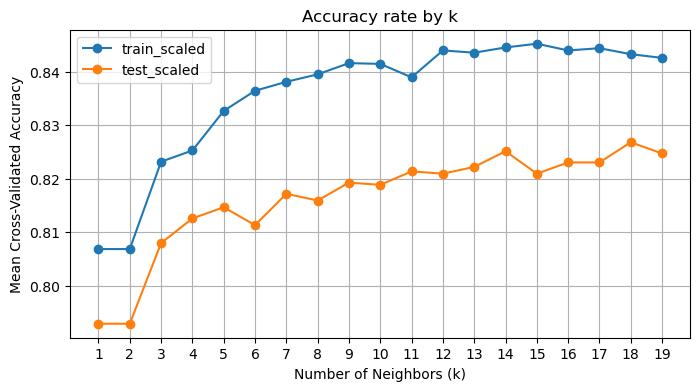

Train_scaled has best k = 15 while test_scaled's best k = 18
Overall accuracy rate is higher when k = 15


In [20]:
# Extract k values and their corresponding mean cross-validated accuracy
k_values = grid_search.cv_results_['param_n_neighbors'].data.astype(int)
mean_accuracy = grid_search.cv_results_['mean_test_score']

k_values_test = grid_search2.cv_results_['param_n_neighbors'].data.astype(int)
mean_accuracy_test = grid_search2.cv_results_['mean_test_score']

# Plot the journey of finding the best k
plt.figure(figsize=(8, 4))
plt.plot(k_values, mean_accuracy, marker='o', label = 'train_scaled')
plt.plot(k_values_test, mean_accuracy_test, marker='o', label = 'test_scaled')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('Accuracy rate by k')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(np.arange(1, 20, 1)) 
plt.show()
print("Train_scaled has best k = 15 while test_scaled's best k = 18")
print("Overall accuracy rate is higher when k = 15")

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion Matrix
cm = confusion_matrix(y_test,y_pred,labels=[0,1])

print("Confusion Matrix:")
print(cm)

y_train_pred = knn_model.predict(X_train_scaled)
y_test_pred = knn_model.predict(X_test_scaled)

# Calculate in-sample accuracy score
in_sample_accuracy = accuracy_score(y_train, y_train_pred)
print(f"In-Sample Accuracy: {in_sample_accuracy:.2f}")

# Calculate out-of-sample accuracy score
out_of_sample_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy:.2f}")

# Calculate the F1-score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pred)
print('f1 score:', f1)

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1670
           1       0.78      0.65      0.71       715

    accuracy                           0.84      2385
   macro avg       0.82      0.78      0.80      2385
weighted avg       0.84      0.84      0.84      2385

Confusion Matrix:
[[1541  129]
 [ 253  462]]
In-Sample Accuracy: 0.86
Out-of-Sample Accuracy: 0.84
f1 score: 0.7075038284839203


CONFUSION MATRIX


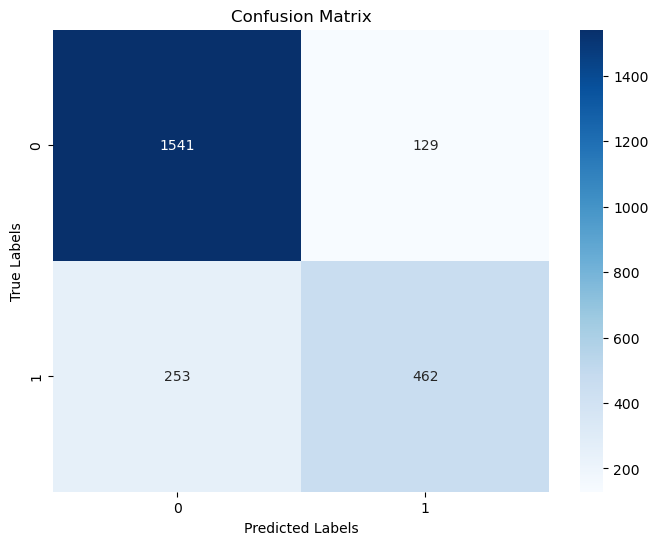

In [22]:
#Plot Confusion Matrix
print("CONFUSION MATRIX")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
# Apply SMOTE only to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Create and train a KNN classifier on the resampled training data
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model on the test data
print(classification_report(y_test, y_pred))

#Confusion Matrix
cm = confusion_matrix(y_test,y_pred,labels=[0,1])

# Calculate in-sample accuracy score
in_sample_accuracy = accuracy_score(y_train_resampled, y_train_resampled)
print(f"In-Sample Accuracy: {in_sample_accuracy:.2f}")

# Calculate out-of-sample accuracy score
out_of_sample_accuracy = accuracy_score(y_test, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy:.2f}")

# Calculate the F1-score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print('f1 score:', f1)

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1670
           1       0.61      0.83      0.70       715

    accuracy                           0.79      2385
   macro avg       0.76      0.80      0.77      2385
weighted avg       0.82      0.79      0.80      2385

In-Sample Accuracy: 1.00
Out-of-Sample Accuracy: 0.79
f1 score: 0.7025428740390303


CONFUSION MATRIX


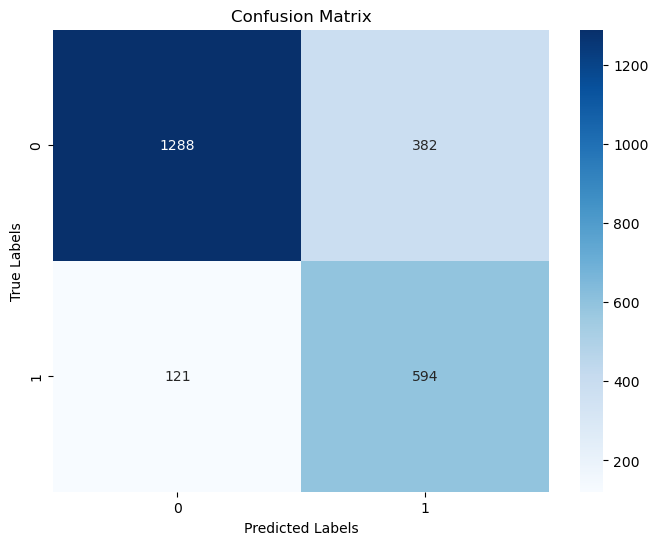

In [24]:
#Plot Confusion Matrix
print("CONFUSION MATRIX")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Visualize the results of KNN

## - Feature importance 

         Feature  Importance
7  avg_hrs_month    0.126541
5   satisfaction    0.124612
4         tenure    0.082725
1         review    0.071740
2       projects    0.003438
6          bonus    0.002390
0       promoted    0.002096
3         salary    0.000629
promoted: Feature
review: Importance


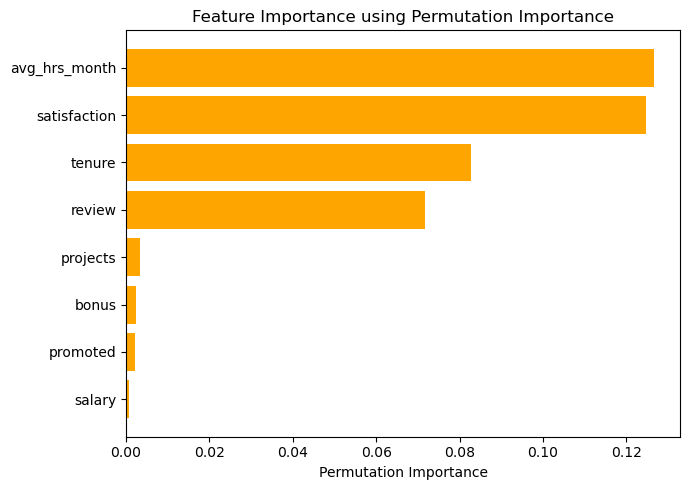

In [33]:
from sklearn.inspection import permutation_importance

# Get feature importance using permutation importance
result = permutation_importance(knn_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to store the feature importances and their names
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})

# Sort the features based on importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


# Plot the feature importances
plt.figure(figsize=(7, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color = 'orange')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature on top
plt.tight_layout()
plt.show()

## - Decision boundary 

- which all boil downs to "Balancing the dataset works for clarifying division in KNN!"

### 1. Using all the variables using 2D PCA (imbalanced data)

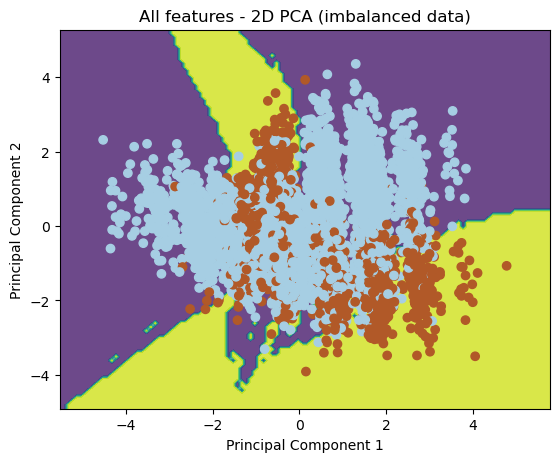

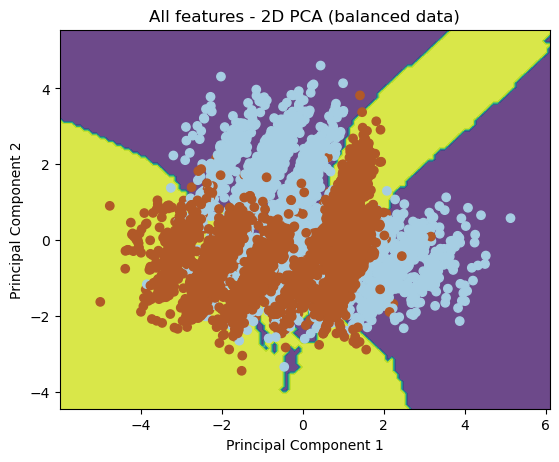

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,1, )

# Apply PCA to reduce data to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Fit the classifier to the resampled training data
knn.fit(X_train_pca, y_train)

# Predict the target values on the test set
y_pred = knn.predict(X_train_pca)

# Plot the decision boundary in 2D
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Paired)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('All features - 2D PCA (imbalanced data)')
plt.show()




# 2-2. Using all the variables using 2D PCA (after balancing data - SMOTE)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,2, )

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Apply PCA to reduce data to 2D
pca = PCA(n_components=2, random_state = 101)
X_train_pca = pca.fit_transform(X_train_resampled)

# Fit the classifier to the resampled training data
knn.fit(X_train_pca, y_train_resampled)

# Predict the target values on the test set
y_pred = knn.predict(X_train_pca)

# Plot the decision boundary in 2D
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_resampled, cmap=plt.cm.Paired)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('All features - 2D PCA (balanced data)')
plt.show()

### Impactful features by PCA

In [27]:
# Get the principal components (eigenvectors)
principal_components = pca.components_
principal_components

# Print the weights of original features for the first two principal components
for i in range(2):  # Two principal components (x and y)
    print(f"Principal Component {i+1}:")
    for j, feature_weight in enumerate(principal_components[i]):
        print(f"Feature {j+1}: {feature_weight:.4f}")
    print()
    
print("-----The most heavily considered factor by PCA-----")
print("Component1 : avg_hrs_month 0.6245, tenure 0.6221, review -0.4453")
print("Component2 : satisfaction 0.7085, review -0.5691")

Principal Component 1:
Feature 1: -0.0044
Feature 2: -0.4453
Feature 3: 0.0026
Feature 4: 0.0080
Feature 5: 0.6221
Feature 6: 0.1568
Feature 7: -0.0012
Feature 8: 0.6245

Principal Component 2:
Feature 1: -0.0489
Feature 2: -0.5691
Feature 3: -0.0229
Feature 4: -0.0074
Feature 5: -0.3004
Feature 6: 0.7085
Feature 7: -0.0059
Feature 8: -0.2846

-----The most heavily considered factor by PCA-----
Component1 : avg_hrs_month 0.6245, tenure 0.6221, review -0.4453
Component2 : satisfaction 0.7085, review -0.5691


### 2. Avg_hrs_month vs Satisfaction (using imbalanced data  VS balanced data)

In [28]:
X

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month
0,0,0.577569,3,0,5.0,0.626759,0,180.866070
1,0,0.751900,3,1,6.0,0.443679,0,182.708149
2,0,0.722548,3,1,6.0,0.446823,0,184.416084
3,0,0.675158,4,2,8.0,0.440139,0,188.707545
4,0,0.676203,3,2,5.0,0.577607,1,179.821083
...,...,...,...,...,...,...,...,...
9535,0,0.610988,4,1,8.0,0.543641,0,188.155738
9536,0,0.746887,3,1,8.0,0.549048,0,188.176164
9537,0,0.557980,3,0,7.0,0.705425,0,186.531008
9538,0,0.584446,4,1,8.0,0.607287,1,187.641370


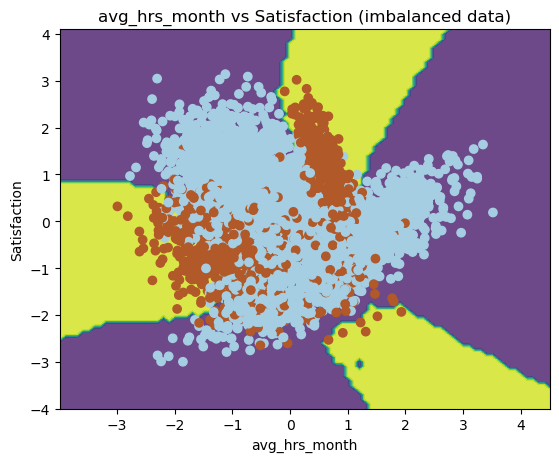

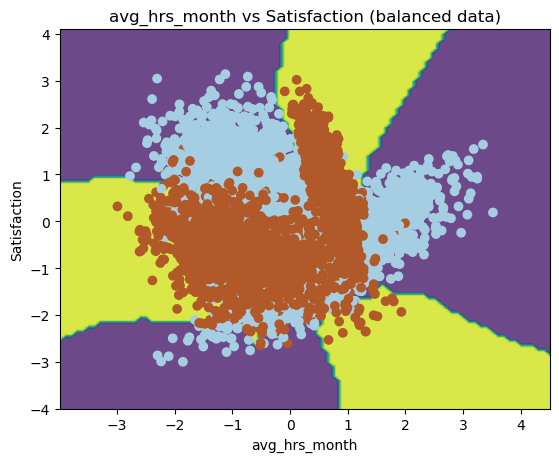

In [29]:
# 1-1. imbalanced data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,1, )

# Select two features for visualization (e.g., feature_1 and feature_2)
feature_1_idx = 7  # avg_hrs_month
feature_2_idx = 5  # satisfaction

# Create a meshgrid for the two selected features
x_min, x_max = X_train_scaled[:, feature_1_idx].min() - 1, X_train_scaled[:, feature_1_idx].max() + 1
y_min, y_max = X_train_scaled[:, feature_2_idx].min() - 1, X_train_scaled[:, feature_2_idx].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create the KNN model using the two selected features
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled[:, [feature_1_idx, feature_2_idx]], y_train)

# Predict the class for each point in the meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)

# Overlay the scatter plot of the actual data points
plt.scatter(X_train_scaled[:, feature_1_idx], X_train_scaled[:, feature_2_idx], c=y_train, cmap=plt.cm.Paired)

plt.xlabel('avg_hrs_month')
plt.ylabel('Satisfaction')
plt.title('avg_hrs_month vs Satisfaction (imbalanced data)')
plt.show()



### 1-2. Avg_hrs_month vs Satisfaction (after balancing data- using SMOTE)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,2, )

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Fit the classifier to the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Predict the target values on the test set
y_pred = knn.predict(X_train_resampled)

# Select two features for visualization (e.g., feature_1 and feature_2)
feature_1_idx = 7  # avg_hrs_month
feature_2_idx = 5  # satisfaction

# Create a meshgrid for the two selected features
x_min, x_max = X_train_resampled[:, feature_1_idx].min() - 1, X_train_resampled[:, feature_1_idx].max() + 1
y_min, y_max = X_train_resampled[:, feature_2_idx].min() - 1, X_train_resampled[:, feature_2_idx].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create the KNN model using the two selected features
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_resampled[:, [feature_1_idx, feature_2_idx]], y_train_resampled)

# Predict the class for each point in the meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)

# Overlay the scatter plot of the actual data points
plt.scatter(X_train_resampled[:, feature_1_idx], X_train_resampled[:, feature_2_idx], c=y_train_resampled, cmap=plt.cm.Paired)

plt.xlabel('avg_hrs_month')
plt.ylabel('Satisfaction')
plt.title('avg_hrs_month vs Satisfaction (balanced data)')
plt.show()

In [30]:
X_train

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month
1281,0,0.506971,4,0,7.0,0.629889,0,185.021553
5809,0,0.570455,4,1,8.0,0.401497,0,189.479494
8346,0,0.496894,3,1,7.0,0.498574,0,187.167897
9354,0,0.594790,4,1,8.0,0.550278,1,187.764929
8341,0,0.752770,3,1,8.0,0.543923,0,188.672543
...,...,...,...,...,...,...,...,...
5734,0,0.615988,4,2,7.0,0.469655,0,186.205256
5191,0,0.649485,4,1,7.0,0.386722,0,186.266620
5390,0,0.571402,4,1,7.0,0.449136,0,185.163044
860,0,0.656328,3,1,5.0,0.516865,0,180.140280


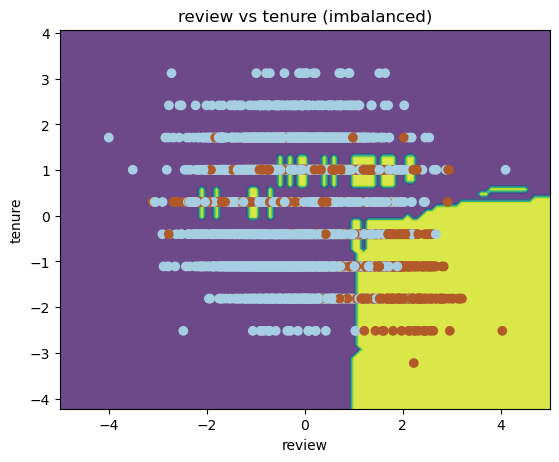

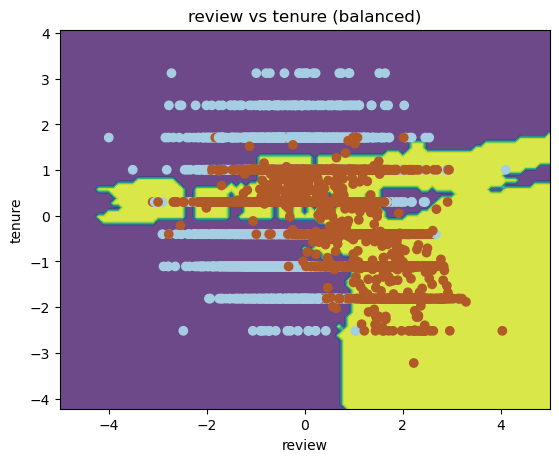

In [31]:
# 1-1. imbalanced data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,1, )

# Select two features for visualization (e.g., feature_1 and feature_2)
feature_1_idx = 1  # review
feature_2_idx = 4  # tenure

# Create a meshgrid for the two selected features
x_min, x_max = X_train_scaled[:, feature_1_idx].min() - 1, X_train_scaled[:, feature_1_idx].max() + 1
y_min, y_max = X_train_scaled[:, feature_2_idx].min() - 1, X_train_scaled[:, feature_2_idx].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create the KNN model using the two selected features
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled[:, [feature_1_idx, feature_2_idx]], y_train)

# Predict the class for each point in the meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)

# Overlay the scatter plot of the actual data points
plt.scatter(X_train_scaled[:, feature_1_idx], X_train_scaled[:, feature_2_idx], c=y_train, cmap=plt.cm.Paired)

plt.xlabel('review')
plt.ylabel('tenure')
plt.title('review vs tenure (imbalanced)')
plt.show()



### 1-2. Avg_hrs_month vs Satisfaction (after balancing data- using SMOTE)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Putting into subplot
plt.figure(figsize=(7,7))
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=1.4, wspace=0.3, hspace=0.4)
plt.subplot(2,1,2, )

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Fit the classifier to the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Predict the target values on the test set
y_pred = knn.predict(X_train_resampled)

# Select two features for visualization (e.g., feature_1 and feature_2)
feature_1_idx = 1  # avg_hrs_month
feature_2_idx = 4  # satisfaction

# Create a meshgrid for the two selected features
x_min, x_max = X_train_resampled[:, feature_1_idx].min() - 1, X_train_resampled[:, feature_1_idx].max() + 1
y_min, y_max = X_train_resampled[:, feature_2_idx].min() - 1, X_train_resampled[:, feature_2_idx].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create the KNN model using the two selected features
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_resampled[:, [feature_1_idx, feature_2_idx]], y_train_resampled)

# Predict the class for each point in the meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)

# Overlay the scatter plot of the actual data points
plt.scatter(X_train_resampled[:, feature_1_idx], X_train_resampled[:, feature_2_idx], c=y_train_resampled, cmap=plt.cm.Paired)

plt.xlabel('review')
plt.ylabel('tenure')
plt.title('review vs tenure (balanced)')
plt.show()

** It's not gonna find out any patterns.

### memo

When you are using a KNN classifier to predict binary values (e.g., churn happened or not), you would expect the model to classify instances into only two classes, resulting in a binary decision boundary. However, in your case, if you observe 3-4 groups differentiated by colors in the plot, it suggests that the KNN model is misclassifying some instances, leading to multiple regions with different colors.

The possible reasons for this behavior could be:

- Class imbalance: If your dataset has an imbalanced distribution of the target classes (e.g., significantly more samples of one class than the other), the KNN model might struggle to correctly classify the minority class, leading to misclassifications.

- Non-linear decision boundary: KNN is a non-parametric method and can capture complex, non-linear decision boundaries. If your data is not well-separated by a linear boundary, KNN might create regions with different colors corresponding to different decision boundaries.

- Irrelevant features: The presence of irrelevant or noisy features in your dataset might introduce additional patterns in the data, leading to the formation of multiple decision regions.